✅ Dataset Loaded. Shape: (10041, 25)
Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'total_ipc_crimes', 'murder_mean', 'murder_std', 'rape_mean', 'rape_std', 'robbery_mean', 'robbery_std', 'dacoity_mean', 'dacoity_std', 'arson_mean', 'arson_std', 'theft_mean', 'theft_std', 'total_ipc_crimes_mean', 'total_ipc_crimes_std', 'is_hotspot', 'district_id']
Train size: (8032, 23), Test size: (2009, 23)

📊 LogisticRegression
Accuracy: 0.930, CrossVal: 0.919
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1504
           1       0.95      0.76      0.84       505

    accuracy                           0.93      2009
   macro avg       0.94      0.87      0.90      2009
weighted avg       0.93      0.93      0.93      2009


📊 RandomForest
Accuracy: 1.000, CrossVal: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1504
           1       1.

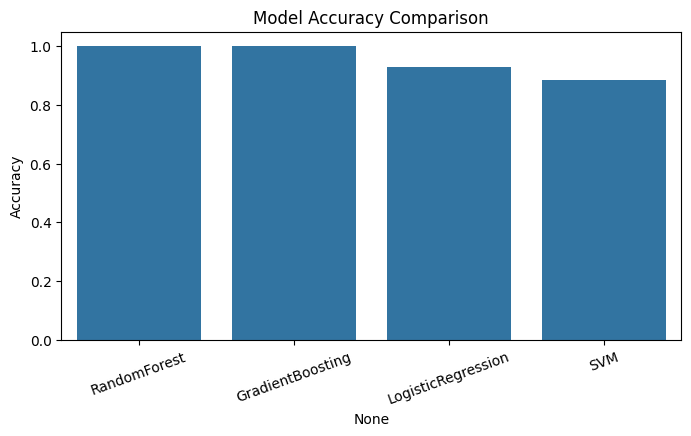

🏆 Best Model: RandomForest | Accuracy: 1.000
✅ Results saved to ../results/model_performance.csv


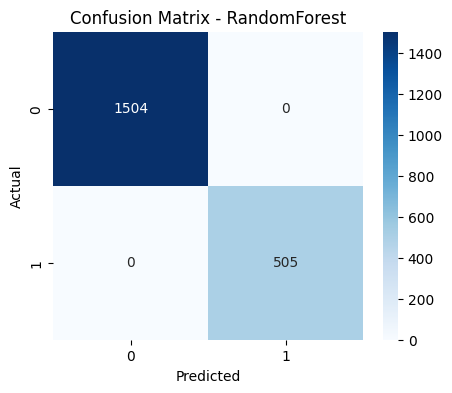

✅ Test predictions saved to ../results/test_predictions.csv
🎯 Modelling Stage Completed Successfully.


In [1]:
# ===============================================================
# CrimeNet - 04_Modelling.ipynb
# ===============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pathlib import Path

# ===============================================================
# 1️⃣ Load Preprocessed Dataset
# ===============================================================
data_path = Path("../data/processed/crime_district_processed.csv")

if not data_path.exists():
    raise FileNotFoundError(f"❌ File not found: {data_path}. Please run 01 & 02 notebooks first.")

df = pd.read_csv(data_path)
print("✅ Dataset Loaded. Shape:", df.shape)
print("Columns:", list(df.columns))

# ===============================================================
# 2️⃣ Data Preparation
# ===============================================================
df.fillna(0, inplace=True)

if "is_hotspot" not in df.columns:
    print("⚠️ No hotspot label found. Creating new target variable...")
    threshold = df["total_ipc_crimes_mean"].quantile(0.75)
    df["is_hotspot"] = (df["total_ipc_crimes_mean"] >= threshold).astype(int)

X = df.drop(columns=["district", "is_hotspot"], errors="ignore")
y = df["is_hotspot"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# ===============================================================
# 3️⃣ Model Training
# ===============================================================
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    cv = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()
    results[name] = {"Accuracy": acc, "CV_Score": cv}
    print(f"\n📊 {name}")
    print(f"Accuracy: {acc:.3f}, CrossVal: {cv:.3f}")
    print(classification_report(y_test, preds))

# ===============================================================
# 4️⃣ Compare Model Performance
# ===============================================================
res_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)
print("\n=== Final Model Results ===")
print(res_df)

plt.figure(figsize=(8,4))
sns.barplot(x=res_df.index, y=res_df["Accuracy"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()

# ===============================================================
# 5️⃣ Save Best Model + Results
# ===============================================================
best_model_name = res_df.index[0]
best_acc = res_df.iloc[0]["Accuracy"]
print(f"🏆 Best Model: {best_model_name} | Accuracy: {best_acc:.3f}")

os.makedirs("../results", exist_ok=True)
res_df.to_csv("../results/model_performance.csv", index=True)
print("✅ Results saved to ../results/model_performance.csv")

# ===============================================================
# 6️⃣ Confusion Matrix Visualization for Best Model
# ===============================================================
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================================================
# 7️⃣ Save Predictions for Later GNN Integration
# ===============================================================
df_results = X_test.copy()
df_results["Actual"] = y_test.values
df_results["Predicted"] = y_pred
df_results.to_csv("../results/test_predictions.csv", index=False)

print("✅ Test predictions saved to ../results/test_predictions.csv")
print("🎯 Modelling Stage Completed Successfully.")
